# TempAtt exp5: specific analyses of tapping data


### Load & preprocess data

In [35]:
clear
clc
% close all

In [36]:
% define Paths: replace XXX by your own path
origDir = '/XXX/exp5/';
addpath(genpath(origDir)); cd(origDir)

% define data
SUJETS = 1:20;
% SUJETS = []; % to remove the unfinished ones

% Load tapping data
load([origDir 'exp5_tapping.mat']); % TAPP & ORAW

In [37]:
% load data: 2 sessions per participant
IN = [];
for isuj = SUJETS
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18V_' subject '_Listen_1*.mat']);
        load([ifile(end).name]) 
        IN{isuj,1}  = X;
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18V_' subject '_Tracking_1*.mat']);
        load([ifile(end).name]) 
        IN{isuj,2}  = X;
    clear X subject ifile
end

In [38]:
% extract data
beats = cfg.fbeat(end:-1:1);
PERF = NaN(SUJETS(end), length(cfg.fbeat), 2, 2*cfg.ntrial);
for isuj = SUJETS
    out = [];
    for itapp = 1:2
        for ibeat = 1:length(beats)
            y = IN{isuj,itapp}.beat == beats(ibeat);
            out{1}(ibeat,itapp,:) = IN{isuj,itapp}.iscor(y);
            out{2}(ibeat,itapp,:) = IN{isuj,itapp}.rt(y);
        end
    end
    % remove RT >2 sec
        rtmax = 2; % in sec
        out{2}(out{2}>rtmax) = NaN; % rt outliers (+2sd)
        out{1}(out{2}>rtmax) = NaN;
        PERF(isuj,:,:,:) = out{1};
end
nbeat = length(beats); ntrial = size(PERF,4);
nsuj  = size(PERF,1);
clear x y rtmax out IN  isuj itapp ibeat cfg subject


% Compute Phase of tapping relative to the beat
LAG = nan(SUJETS(end), nbeat, 1, ntrial);
PHY = nan(SUJETS(end), nbeat);
for isuj = SUJETS
    for ibeat = 1:nbeat
    phy = NaN(ntrial,1);
        for itrial = 1:ntrial
            ntones = length(ORAW{isuj, ibeat, 1}{itrial} - 1);
            if ntones >= 1
                temp = round( ORAW{isuj,ibeat,1}{itrial} -333 ); % in ms
                temp = mod( temp, 1e3/beats(ibeat)); % circular
                temp = temp*(beats(ibeat)/1e3)*2*pi; % normalized
                LAG(isuj,ibeat,1,itrial) = abs(circ_mean(temp)); % abs mean
                phy(itrial) = circ_mean(temp); % mean
                clear temp ntones
            end
        end
        phy(isnan(phy)) = [];
        PHY(isuj,ibeat) = circ_mean(phy);
    end
end
clear isuj ibeat itrial ORAW

In [ ]:
% save lag data between motor tapping & beat
save('exp5_lag.mat', 'LAG') % LAG

In [39]:
% sort data (2 choices)
Gp = []; rawt = []; rawp = []; T = []; P = [];
for isuj = 1:nsuj
    for ibeat = 1:nbeat
        perf = squeeze(PERF(isuj,ibeat,2,:)); % 1=listen, 2=tracking
        % tapp: cv of tapping-speed
        tapp = squeeze(TAPP(isuj,ibeat,2,:))*100; % 2=cv
            yy = [0, 30]; ynam = 'Coefficient of variation (%)';
        
        Gp(isuj,ibeat, 1) = nanmean(tapp(perf==1)); % sort fn perf
            Gp(isuj,ibeat, 2) = nanmean(tapp(perf==0));        
        [tapp,id] = sort(tapp); perf = perf(id); % sort fn tapp
        rawt(isuj,ibeat, :) = tapp; 
        rawp(isuj,ibeat, :) = perf;        
        T(isuj,ibeat, 1) = nanmean(tapp(1:20)); % sort fn tapp
            T(isuj,ibeat, 2) = nanmean(tapp(21:end));
        P(isuj,ibeat, 1) = nanmean(perf(1:20));
            P(isuj,ibeat, 2) = nanmean(perf(21:end));
    end
end
% replace NaN data (from tapping) by avg across trials (per condition)
for i0 = 1:isuj
    for j0 = 1:ibeat
        for z0 = 1:2
            if isnan(Gp(i0,j0,z0))
                Gp(i0,j0,z0) = nanmean(Gp(:,j0,z0));
            else
                Gp(i0,j0,z0) = Gp(i0,j0,z0);
            end
        end
    end
end
clear perf tapp id isuj ibeat

### Figure

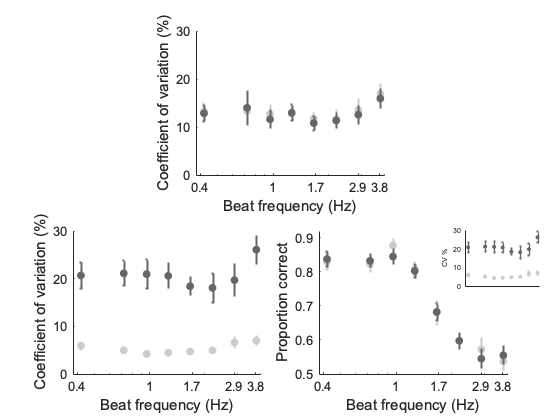

In [40]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% Figure cv fn perf (correct/incorrect)
subplot(2, 2, 1.5); hold on
    x = Gp(:,:,1); % correct
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = Gp(:,:,2); % error
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
	ylim( yy )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.38, 4] )

% Figure: median split of cv
subplot(2, 2, 3); hold on % cv
    x = T(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = T(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( yy )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.38, 4] )

% Figure: perf fn cv (median split)
subplot(2, 2, 4); hold on % perf
    x = P(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = P(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( 'Proportion correct' )
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( [.5, .92] )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.38, 4] )
        
        ax2 = axes('Position',[.83 .32 .2/1.5 .2/1.5]); hold on;
          x = T(:,:,1); % low
            x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
            errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
            'b.', 'color', [.8 .8 .8], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            x = T(:,:,2); % high
            x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
           errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
            'r.', 'color', [.4 .4 .4 ], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
            hold off
            set(gca, 'FontSize', 5, 'FontName', 'Arial')
            ylabel( 'CV %' )        
            ylim( yy )
                set(gca, 'XScale', 'log')
                xticks( [] )
                xlim( [.38, 4] )
            clear x

% Print figure
cd(origDir)
% print('figureS3b&c','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figureS3b&c.pdf


### Statistics

In [41]:
% 1. Anova on corr - incorr
X = Gp;
X(sum(sum(isnan(X),2),3)>0,:,:) = [];
fprintf('\n1.Parametric repeated-measure Anova on performance corr - incorr\n')
[~,F,~,~] = repanova(reshape(X, size(X,1), []), [2, 8], {'cor/inc', 'Beat'});
bf = bftest(diff(mean(X,2),[],3),'bic'); fprintf('BF = %2.2f\n', bf);

% 2. control anova on median split of CV
fprintf('\n2. Parametric repeated-measure Anova on Coeff variation (control) median split of CV \n')
[~,F,~,~] = repanova(reshape(T, size(T,1), []), [2, 8], {'low/high', 'Beat'});
bf = bftest(diff(mean(T,2),[],3),'bic'); fprintf('BF = %2.2f\n', bf);

% 3. Anova on perf CV high - CV low
fprintf('\n3. Parametric repeated-measure Anova on performance CV high - CV low\n')
[~,F,~,~] = repanova(reshape(P, size(T,1), []), [2, 8], {'low/high', 'Beat'});
bf = bftest(diff(mean(P,2),[],3),'bic'); fprintf('BF = %2.2f\n', bf);

clear X bf F


1.Parametric repeated-measure Anova on performance corr - incorr
cor/inc              F(  1.00, 19.00) =   1.308,	p = 0.2669
Beat                 F(  7.00,133.00) =   0.852,	p = 0.4908
cor/inc x Beat       F(  7.00,133.00) =   0.135,	p = 0.8968
BF = 0.44

2. Parametric repeated-measure Anova on Coeff variation (control) median split of CV 
low/high             F(  1.00, 19.00) =  48.512,	p = 0.0000
Beat                 F(  7.00,133.00) =   0.878,	p = 0.4785
low/high x Beat      F(  7.00,133.00) =   0.622,	p = 0.6114
BF = 71739.26

3. Parametric repeated-measure Anova on performance CV high - CV low
low/high             F(  1.00, 19.00) =   0.060,	p = 0.8098
Beat                 F(  7.00,133.00) =  41.763,	p = 0.0000
low/high x Beat      F(  7.00,133.00) =   0.331,	p = 0.8725
BF = 0.23


In [42]:
% Analyse performance fn tapping/beat Lag & vice-versa
% sort data
Gp = []; rawt = []; rawp = []; T = []; P = [];
for isuj = 1:nsuj
    for ibeat = 1:nbeat
        perf = squeeze(PERF(isuj,ibeat,2,:)); % 1=listen, 2=tracking
        tapp = squeeze(LAG(isuj,ibeat,1,:)); % lag
            yy = [0, 2.7]; ynam = '|\phi tapping-beat| (rad)';     
        Gp(isuj,ibeat, 1) = nanmean(tapp(perf==1)); % sort fn perf
            Gp(isuj,ibeat, 2) = nanmean(tapp(perf==0));        
        [tapp,id] = sort(tapp); perf = perf(id); % sort fn tapp
        rawt(isuj,ibeat, :) = tapp; 
        rawp(isuj,ibeat, :) = perf;        
        T(isuj,ibeat, 1) = nanmean(tapp(1:20)); % sort fn tapp
            T(isuj,ibeat, 2) = nanmean(tapp(21:end));
        P(isuj,ibeat, 1) = nanmean(perf(1:20));
            P(isuj,ibeat, 2) = nanmean(perf(21:end));
    end
end
for i0 = 1:isuj
    for j0 = 1:ibeat
        for z0 = 1:2
            if isnan(Gp(i0,j0,z0))
                Gp(i0,j0,z0) = nanmean(Gp(:,j0,z0));
            else
                Gp(i0,j0,z0) = Gp(i0,j0,z0);
            end
        end
    end
end
clear perf tapp id isuj ibeat
% Gp(sum(sum(isnan(Gp),2),3)>0,:,:) = []; % remove NaN participant

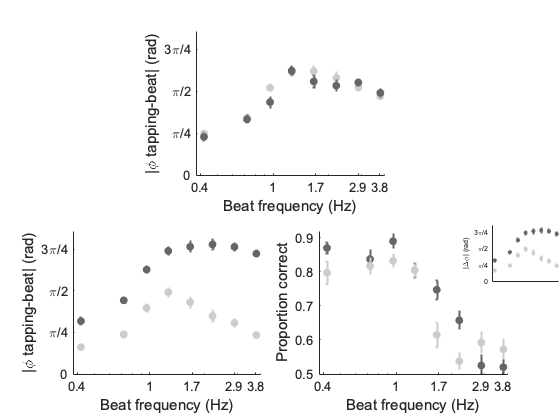

In [43]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% Figure lag fn perf (correct/incorrect)
subplot(2, 2, 1.5); hold on
    x = Gp(:,:,1); % correct
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = Gp(:,:,2); % error
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
	ylim( [0, 2.7] )
    yticks( [0 pi/4 pi/2 3*pi/4] )
    yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
        xticks( round(beats([end:-2:1 1]),1) )       
        set(gca, 'XScale', 'log')
                xlim( [.38, 4] )
% legend({'correct', 'incorrect'})


% Figure: median split of cv
subplot(2, 2, 3); hold on % cv
    x = T(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = T(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
	ylim( [0, 2.7] )
    yticks( [0 pi/4 pi/2 3*pi/4] )
    yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
                xlim( [.38, 4] )

% Figure: perf fn cv (median split)
subplot(2, 2, 4); hold on % perf
 x = P(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = P(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
   
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( 'Proportion correct' )
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( [.5, .92] )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
                xlim( [.38, 4] )
        
    ax2 = axes('Position',[.878 .33 .2/1.7 .2/1.5]); hold on;
          x = T(:,:,1); % low
            x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
            errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
            'b.', 'color', [.8 .8 .8], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            x = T(:,:,2); % high
            x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
           errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
            'r.', 'color', [.4 .4 .4], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
            hold off
            set(gca, 'FontSize', 5, 'FontName', 'Arial')
            ylabel( '|\Delta\phi| (rad)' ) 
            ylim( [0, 2.7] )
            yticks( [0 pi/4 pi/2 3*pi/4] )
            yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
                set(gca, 'XScale', 'log')
                xticks( [] )
                xlim( [.38, 4] )

 
% Print figure
cd(origDir)
% print('figure4d&e','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figure4d&e.pdf


In [44]:
fprintf('\n1.Parametric repeated-measure Anova on performance \n')
[~,F,~,~] = repanova(reshape(Gp, size(Gp,1), []), [2, 8], {'cor/inc', 'Beat'});
bf = bftest(diff(mean(Gp,2),[],3),'aic'); fprintf('BF = %2.2f\n', bf);

fprintf('\n2. Parametric repeated-measure Anova on Coeff variation (control) \n')
[~,F,~,~] = repanova(reshape(T, size(T,1), []), [2, 8], {'low/high', 'Beat'});

fprintf('\n3. Parametric repeated-measure Anova on performance \n')
[~,F,~,~] = repanova(reshape(P, size(T,1), []), [2, 8], {'low/high', 'Beat'});
bf = bftest(diff(mean(P,2),[],3),'aic'); fprintf('BF = %2.2f\n', bf);


% Post-hoc analysis: correct vs. incorrect (beat-by-beat)
fprintf('\n4.Post-hoc analysis: correct vs. incorrect (beat-by-beat) \n ')
for j0 = 1:length(beats)
    [~, p, ~, S] = ttest(Gp(:,j0,1), Gp(:,j0,2));
    bf = bftest(Gp(:,j0,2)-Gp(:,j0,1),'bic'); 
    fprintf('     beat %1.2fhz: p= %6.4f,  t= %6.4f,  df= %6.4f,  bf= %6.4f\n', beats(j0), p, S.tstat, S.df, bf)
    pval(j0) = p;
end


% Post-hoc analysis: low vs. high lag (beat-by-beat)
fprintf('\n5. Post-hoc analysis: low vs. high lag (beat-by-beat) \n')
for j0 = 1:length(beats)
    [~, p, ~, S] = ttest(P(:,j0,1), P(:,j0,2));
    bf = bftest(P(:,j0,2)-P(:,j0,1),'bic'); 
    fprintf('     beat %1.2fhz: p= %6.4f,  t= %6.4f,  df= %6.4f,  bf= %6.4f\n', beats(j0), p, S.tstat, S.df, bf)
    pval(j0) = p;
end

clear x h T P rawt rawp Gp yy ynam F bf


1.Parametric repeated-measure Anova on performance 
cor/inc              F(  1.00, 19.00) =   8.410,	p = 0.0092
Beat                 F(  7.00,133.00) =  31.484,	p = 0.0000
cor/inc x Beat       F(  7.00,133.00) =   4.020,	p = 0.0044
BF = 11.57

2. Parametric repeated-measure Anova on Coeff variation (control) 
low/high             F(  1.00, 19.00) = 796.251,	p = 0.0000
Beat                 F(  7.00,133.00) =  33.098,	p = 0.0000
low/high x Beat      F(  7.00,133.00) =  81.009,	p = 0.0000

3. Parametric repeated-measure Anova on performance 
low/high             F(  1.00, 19.00) =   6.200,	p = 0.0222
Beat                 F(  7.00,133.00) =  41.763,	p = 0.0000
low/high x Beat      F(  7.00,133.00) =   4.555,	p = 0.0019
BF = 4.99

4.Post-hoc analysis: correct vs. incorrect (beat-by-beat) 
      beat 3.82hz: p= 0.3414,  t= -0.9758,  df= 19.0000,  bf= 0.3646
     beat 2.90hz: p= 0.0783,  t= -1.8606,  df= 19.0000,  bf= 1.1924
     beat 2.20hz: p= 0.0560,  t= 2.0355,  df= 19.0000,  bf= 1.6076


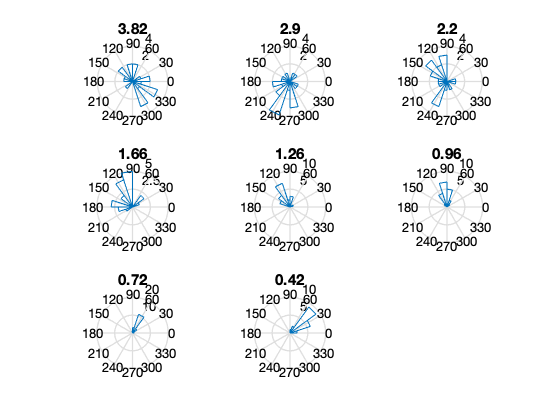

In [45]:
% Figure phase value
f=figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1]);
for ibeat = 1:nbeat
    subplot(3,3,ibeat)
    rose(PHY(:,ibeat)) % the function used to create figure S4 is homemade and can be requested to the corresponding author
    title(num2str(beats(ibeat)))
end
